In [2]:
import pandas as pd 
import geopandas as gpd 

import rasterio
from rasterio.sample import sample_gen 
import laspy

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import matplotlib.pyplot as plt 
import seaborn as sns


In [9]:
def load_data(plot_number: str) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:

    las = laspy.read(f"/home/rafael/Projetos/tree_detection/data/als/plot_{plot_number}.las")

    rgb = rasterio.open(f"/home/rafael/Projetos/tree_detection/data/ortho/plot_{plot_number}.tif")


    ground_level = np.percentile(las.xyz[:, 2], 3)
    las.xyz[:,2] = las.xyz[:,2] - ground_level
    las = las[las.xyz[:, 2] > 2.0]

    points  = pd.DataFrame({
        "x": las.x.copy(),
        "y": las.y.copy(),
        "z": las.z.copy(),
        "intensity": las.intensity.copy()})
    gdf_las = gpd.GeoDataFrame(points,geometry = gpd.points_from_xy(points.x, points.y), crs ="EPSG:32640" )



    gt = gpd.read_file("/home/rafael/Projetos/tree_detection/data/field_survey.geojson")
    ground_truth = gt.query(f"plot=={int(plot_number.lstrip("0") or "0")}")


    coords = [(x,y) for x,y in zip(gdf_las.x,gdf_las.y)]

    r, g, b = [], [], []

    for val in rgb.sample(coords):
        r.append(val[0])
        g.append(val[1])
        b.append(val[2])

    gdf_las["r"] = r
    gdf_las["g"] = g
    gdf_las["b"] = b

    return gdf_las, ground_truth



In [19]:
def match_gt(gdf_las: gpd.GeoDataFrame, ground_truth: gpd.GeoDataFrame,) -> pd.DataFrame:
    trees = ground_truth
    trees["geometry"] = trees.geometry.buffer(0.5)
    gdf_join = gpd.sjoin(gdf_las, trees, predicate = "within", how = "left")

    agg = (
    gdf_join[gdf_join["tree_no"].notna()].groupby("tree_no").agg({
        "z": "mean",
        "r": "mean",
        "g": "mean",
        "b": "mean",
        "x": "mean",
        "y": "mean",
        "intensity": "mean"
    })
    .reset_index()
    )
    agg["is_tree"] = 1
    empty_points = gdf_join[gdf_join["tree_no"].isna()].sample(n = len(agg) * 2)
    empty_points = empty_points.groupby(empty_points.index).agg({
        "x": "mean", "y": "mean", "z": "mean", "r": "mean", "g": "mean", "b": "mean", "intensity": "mean"
    })
    empty_points["is_tree"] = 0

    training_df = pd.concat([agg, empty_points]).reset_index(drop=True)

    return training_df



In [35]:
def viz(training_df: pd.DataFrame, plot_number: str) -> None:
    vble_cols = training_df.select_dtypes(include='number').columns.drop(['is_tree', 'tree_no'])
    n_cols = 3
    n_rows = (len(vble_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for ax, col in zip(axes, vble_cols):
        sns.histplot(data=training_df, x=col, hue='is_tree', kde=True, ax=ax)

    for i in range(len(vble_cols), len(axes)):
        axes[i].set_visible(False)


    plt.tight_layout()
    plt.savefig(f"/home/rafael/Projetos/tree_detection/images/{plot_number}/distribution.png")
    

In [6]:
def model_pipeline(training_df) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, RandomForestClassifier]:

    X = training_df[['z','r','g','b','intensity']].to_numpy()
    y = training_df['is_tree']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rfc_search_space = {
        'n_estimators': range(10, 101),
        'criterion': ['gini', 'entropy'],
        'max_depth': range(2, 51),
        'min_samples_split': range(2, 11),
        'min_samples_leaf': range(1, 11),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }



    rfc = RandomForestClassifier(class_weight = "balanced")



    random_search = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_search_space, n_iter=100, cv=5)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    rfc = RandomForestClassifier(**best_params)


    rfc.fit(X_train, y_train)

    return X_train, X_test, y_train, y_test, rfc

In [ ]:
def evaluate(rfc, X_test, y_test) -> pd.DataFrame:
    y_pred = rfc.predict(X_test)
    report = classification_report(y_pred, y_test, output_dict=True)

    report_df = pd.DataFrame(report).transpose()
    report_df = report_df[:-3]
    return report_df

In [11]:
gdf_las, ground_truth = load_data("01")

In [13]:
ground_truth

,plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
0,1.0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,None,POINT (547075.84 6450425.243)
1,1.0,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,None,POINT (547074.299 6450419.542)
2,1.0,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,None,POINT (547077.454 6450419.994)
3,1.0,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,None,POINT (547078.211 6450419.02)
4,1.0,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,None,POINT (547074.669 6450415.573)
...,...,...,...,...,...,...,...,...,...,...,...
415,1.0,416.0,Aspen,20.1,22.1,21.10,NaN,NaN,0.0,None,POINT (547082.192 6450332.409)
416,1.0,417.0,Aspen,30.9,31.8,31.35,NaN,NaN,0.0,None,POINT (547078.262 6450335.086)
417,1.0,418.0,Aspen,19.1,18.9,19.00,NaN,NaN,0.0,None,POINT (547075.745 6450333.077)
418,1.0,419.0,Aspen,22.0,22.0,22.00,NaN,NaN,0.0,None,POINT (547076.314 6450331.568)


In [20]:
training_df = match_gt(gdf_las, ground_truth)
training_df

,tree_no,z,r,g,b,x,y,intensity,is_tree
0,1.0,202.108366,75.683168,99.435644,59.861386,547075.770465,6.450425e+06,44.900990,1
1,2.0,203.464719,69.424460,105.431655,54.474820,547074.353978,6.450419e+06,46.935252,1
2,3.0,192.950339,43.330709,70.425197,38.748031,547077.473441,6.450420e+06,45.251969,1
3,4.0,198.879942,63.404959,96.809917,52.371901,547078.293645,6.450419e+06,45.355372,1
4,5.0,204.089853,71.945736,109.255814,56.069767,547074.716039,6.450416e+06,46.868217,1
...,...,...,...,...,...,...,...,...,...
1255,NaN,213.273000,92.000000,120.000000,59.000000,547113.527000,6.450342e+06,63.000000,0
1256,NaN,214.158000,44.000000,62.000000,37.000000,547107.936000,6.450356e+06,63.000000,0
1257,NaN,213.989000,44.000000,90.000000,42.000000,547125.535000,6.450336e+06,63.000000,0
1258,NaN,213.650000,76.000000,106.000000,62.000000,547113.909000,6.450357e+06,63.000000,0


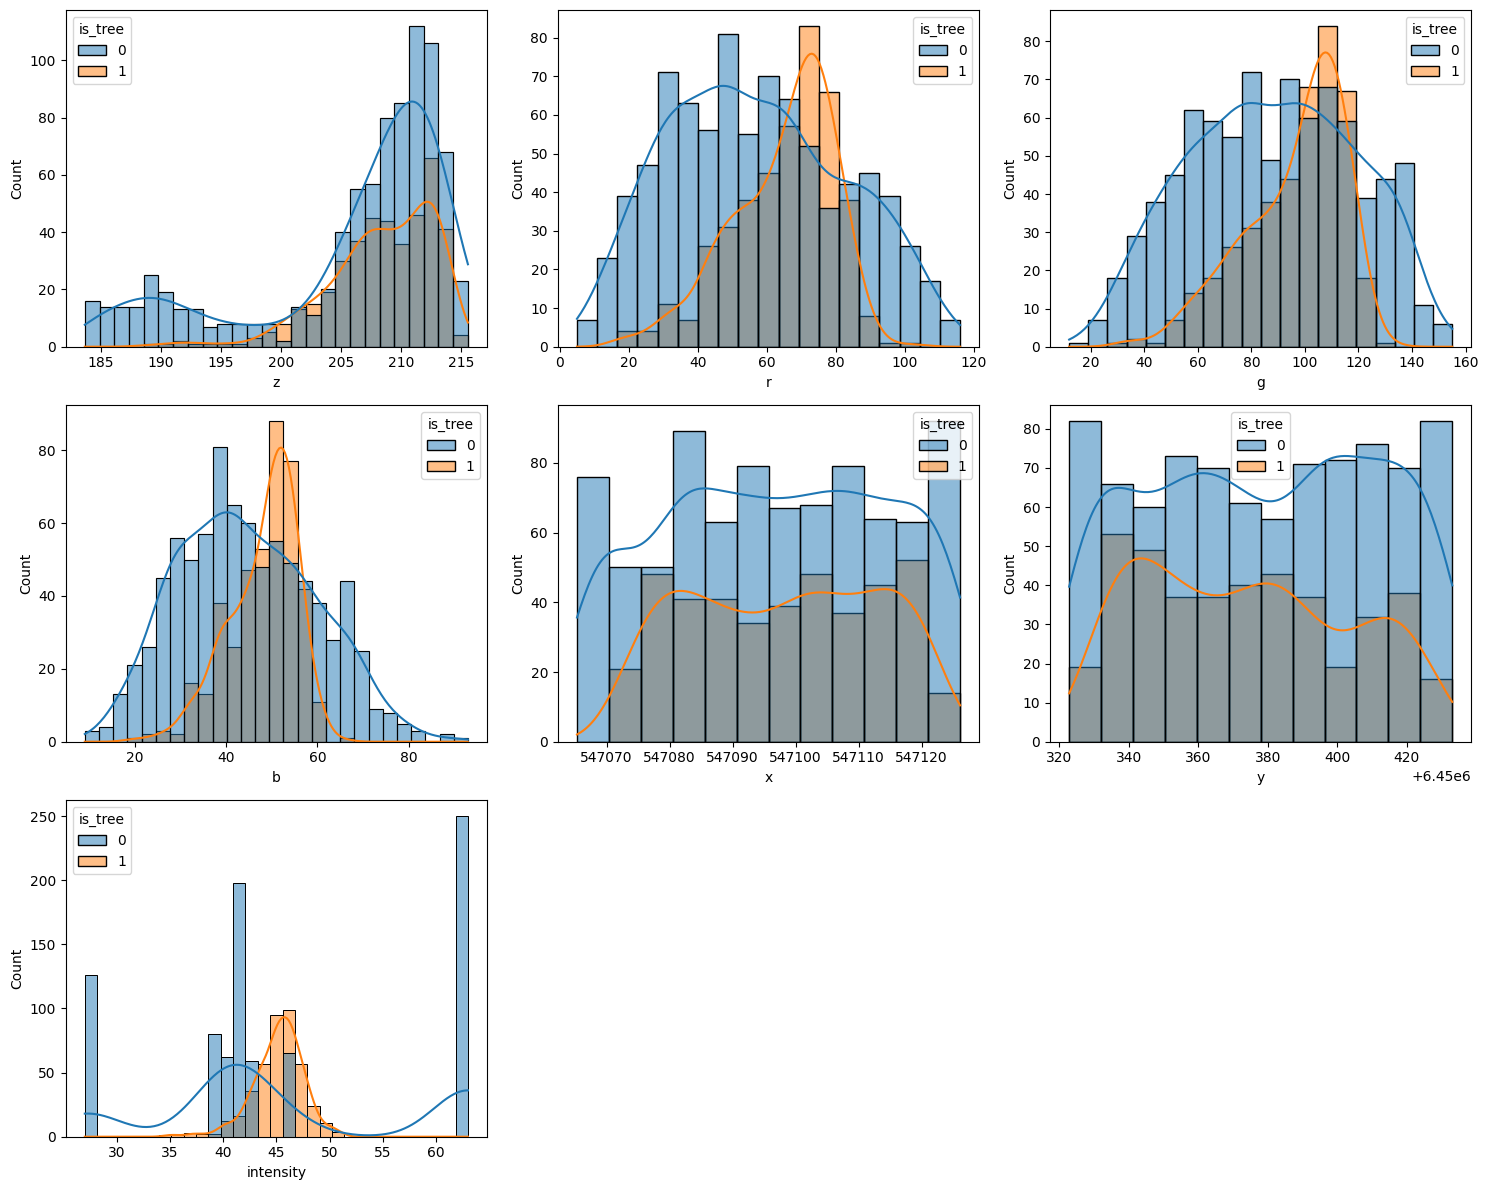

In [23]:
viz(training_df)


In [24]:
X_train, X_test, y_train, y_test, rfc = model_pipeline(training_df)

In [38]:
report_df = evaluate(rfc, X_test, y_test)
report_df[:-3]

,precision,recall,f1-score,support


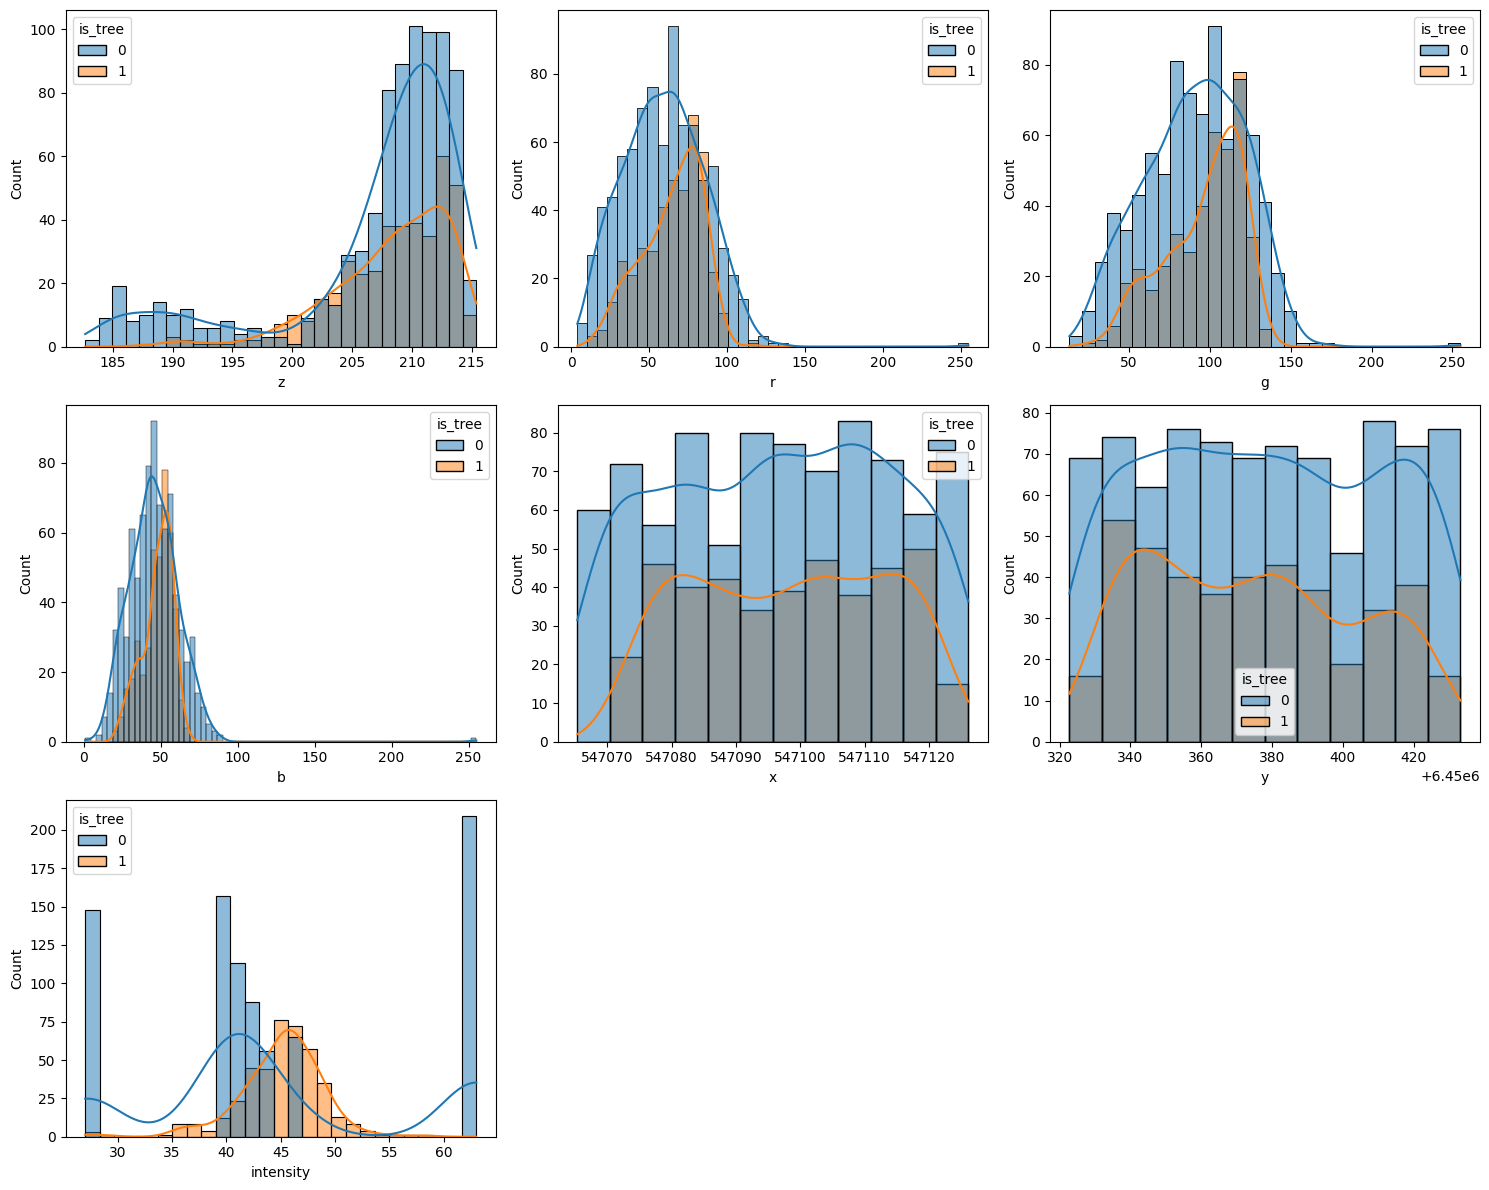

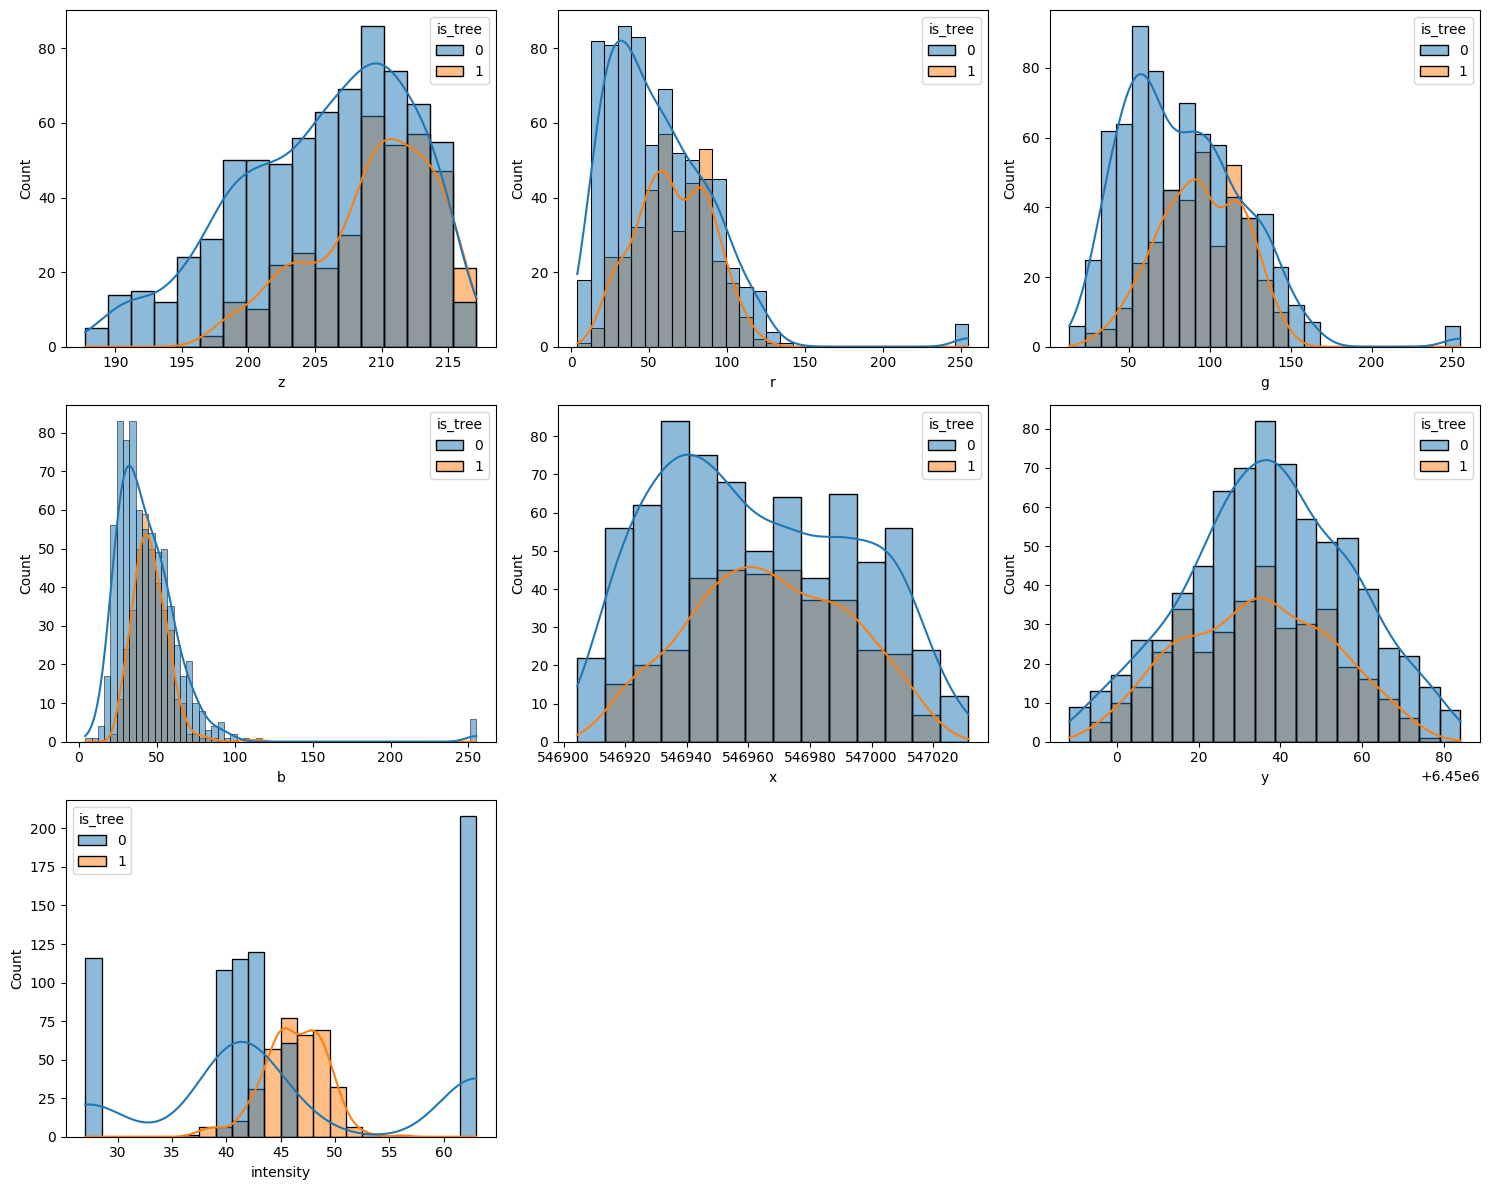

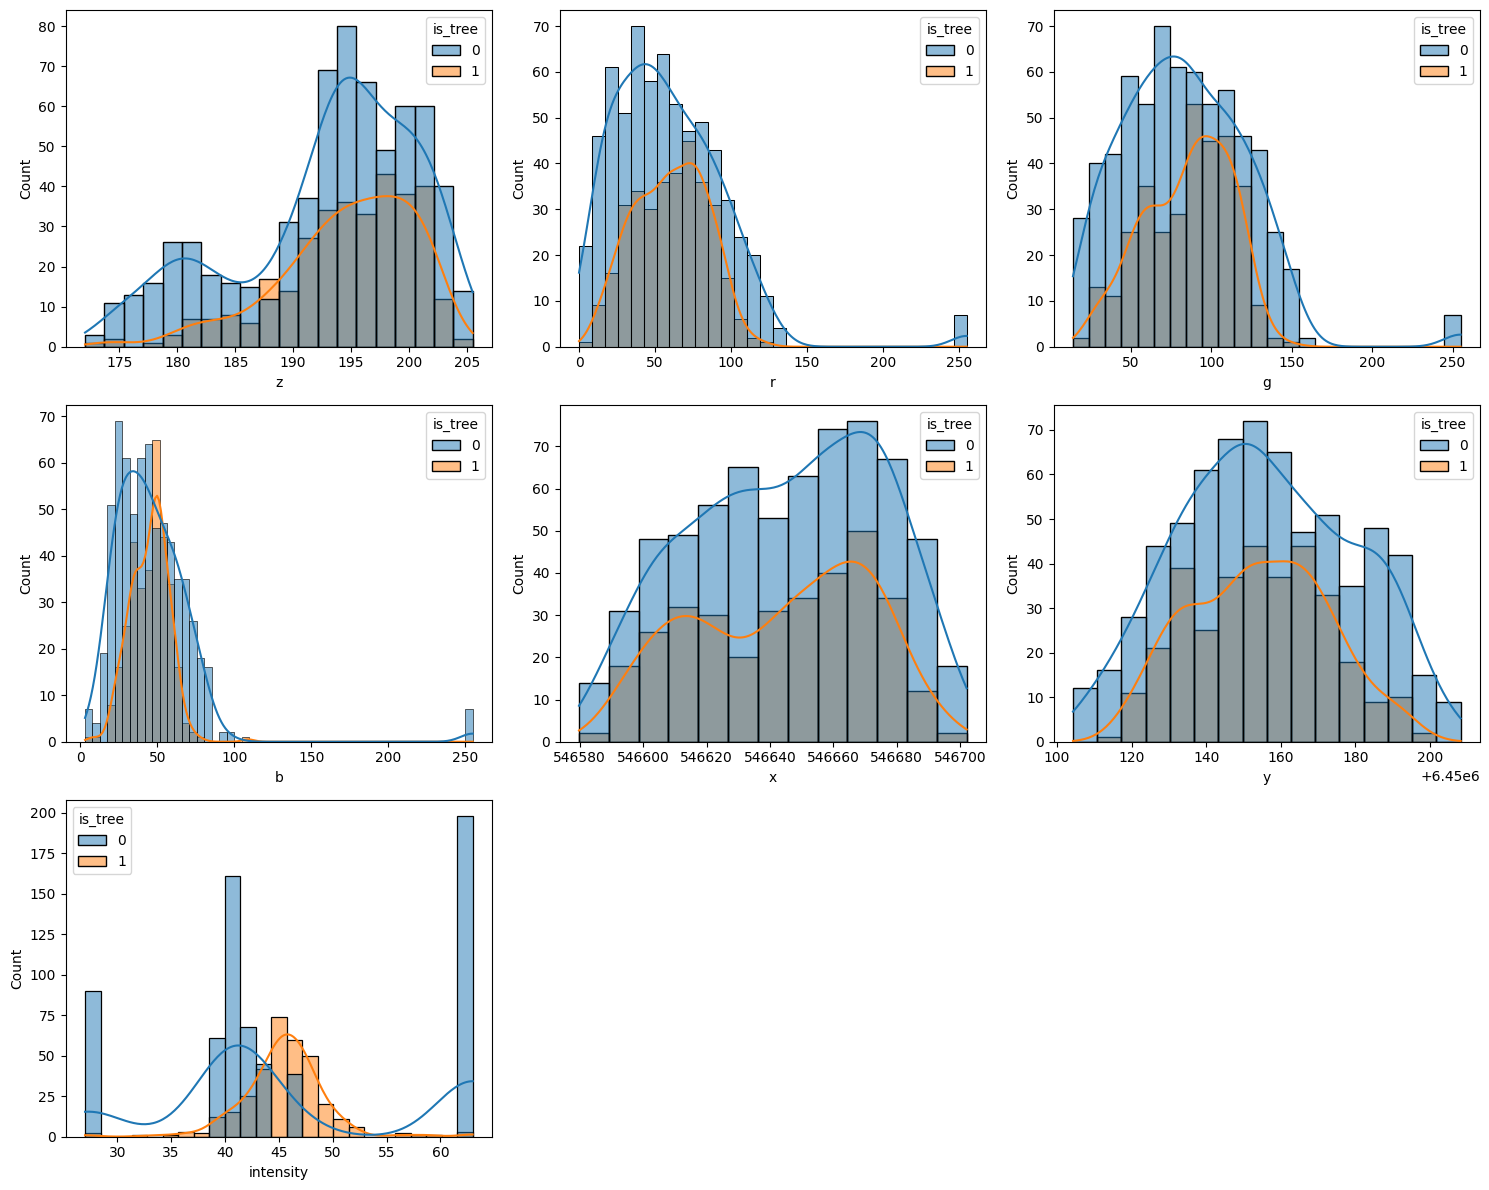

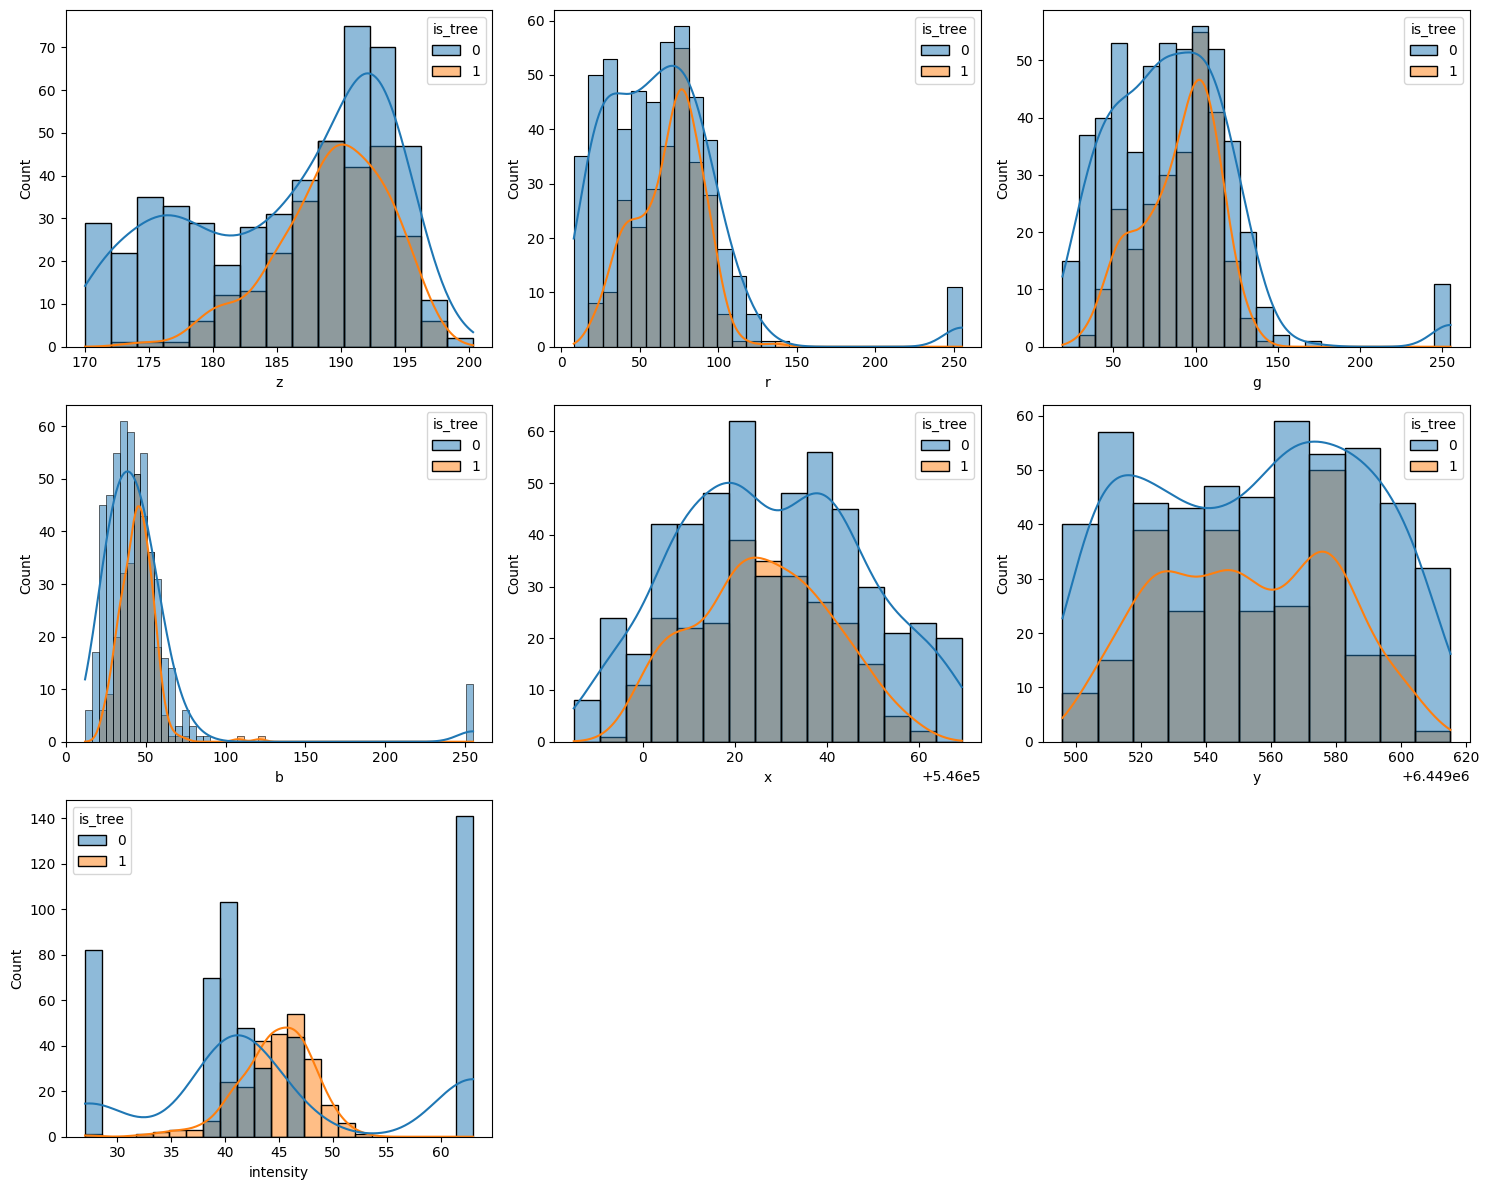

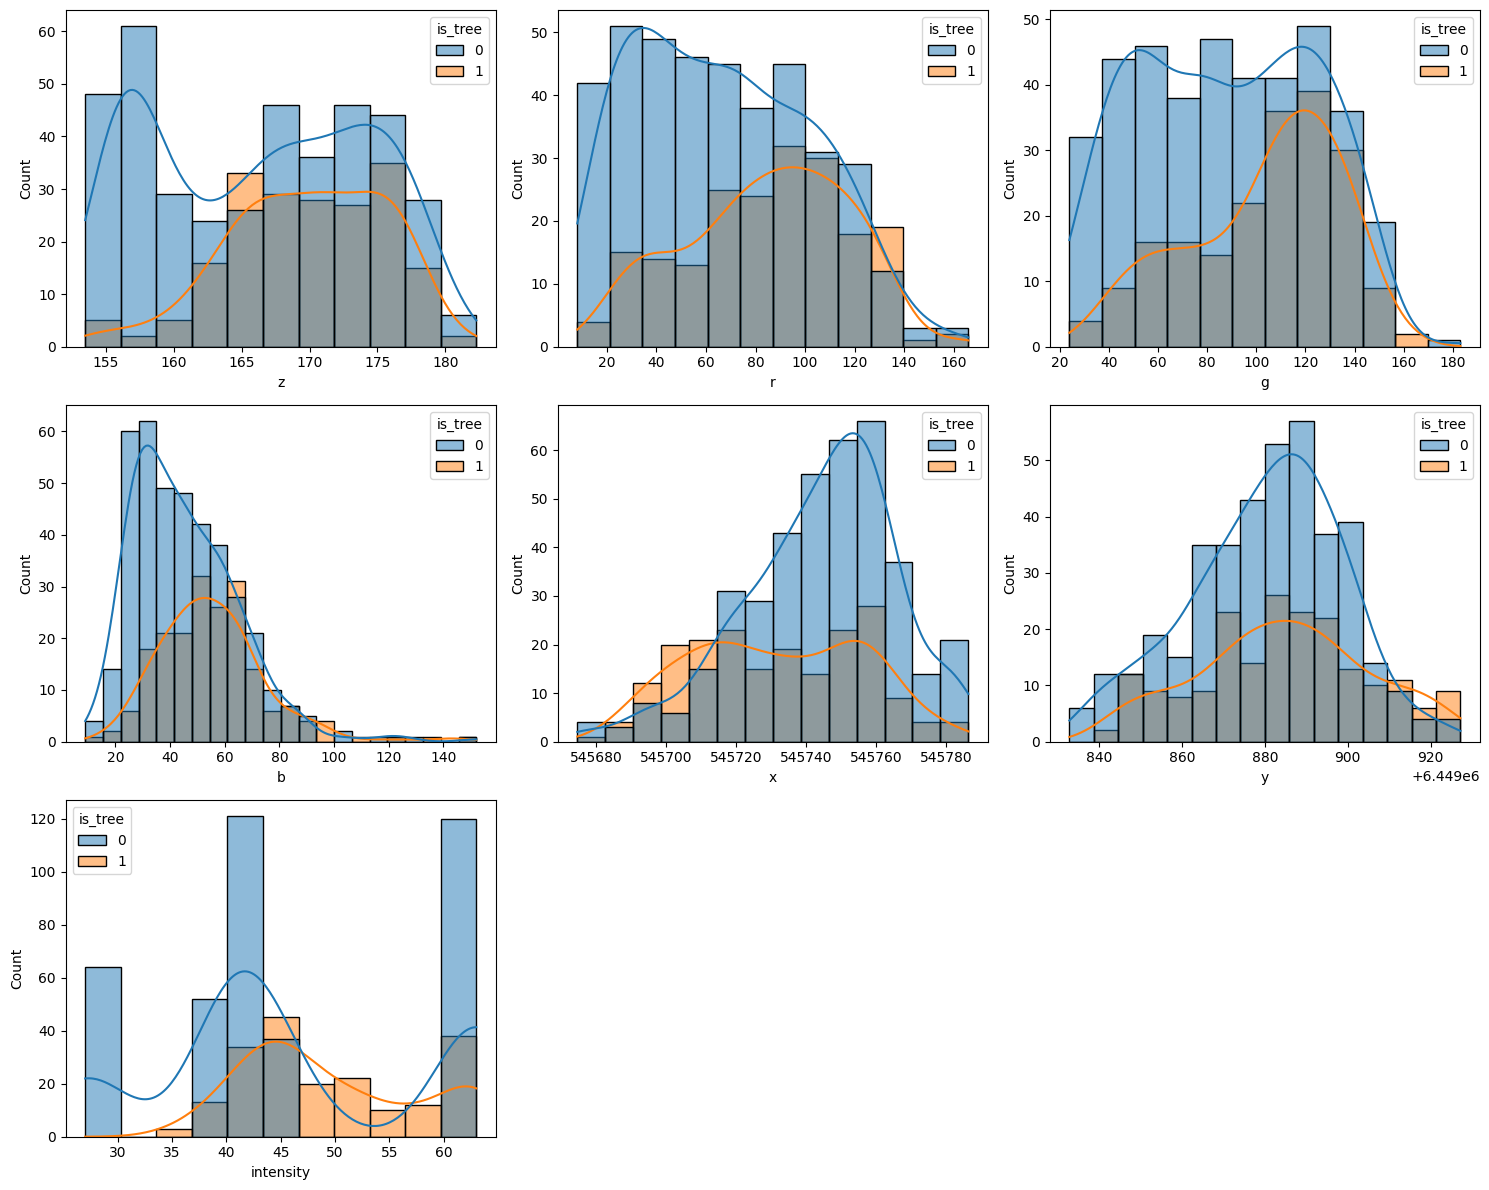

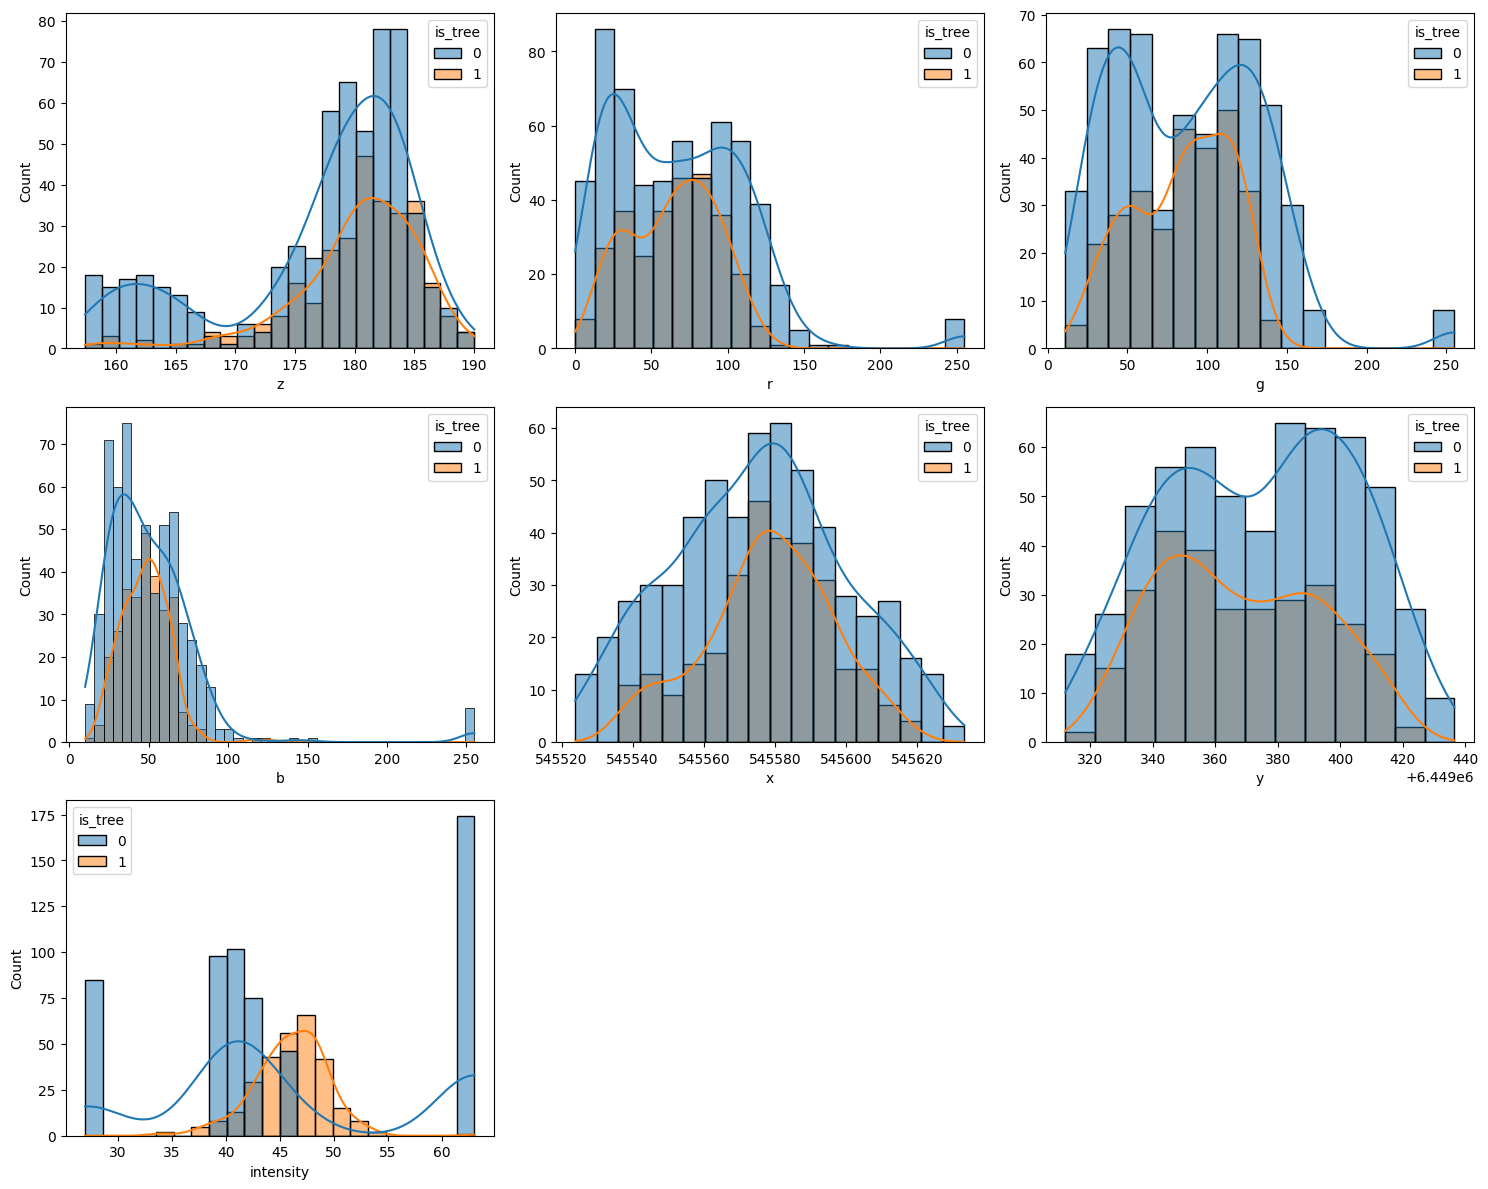

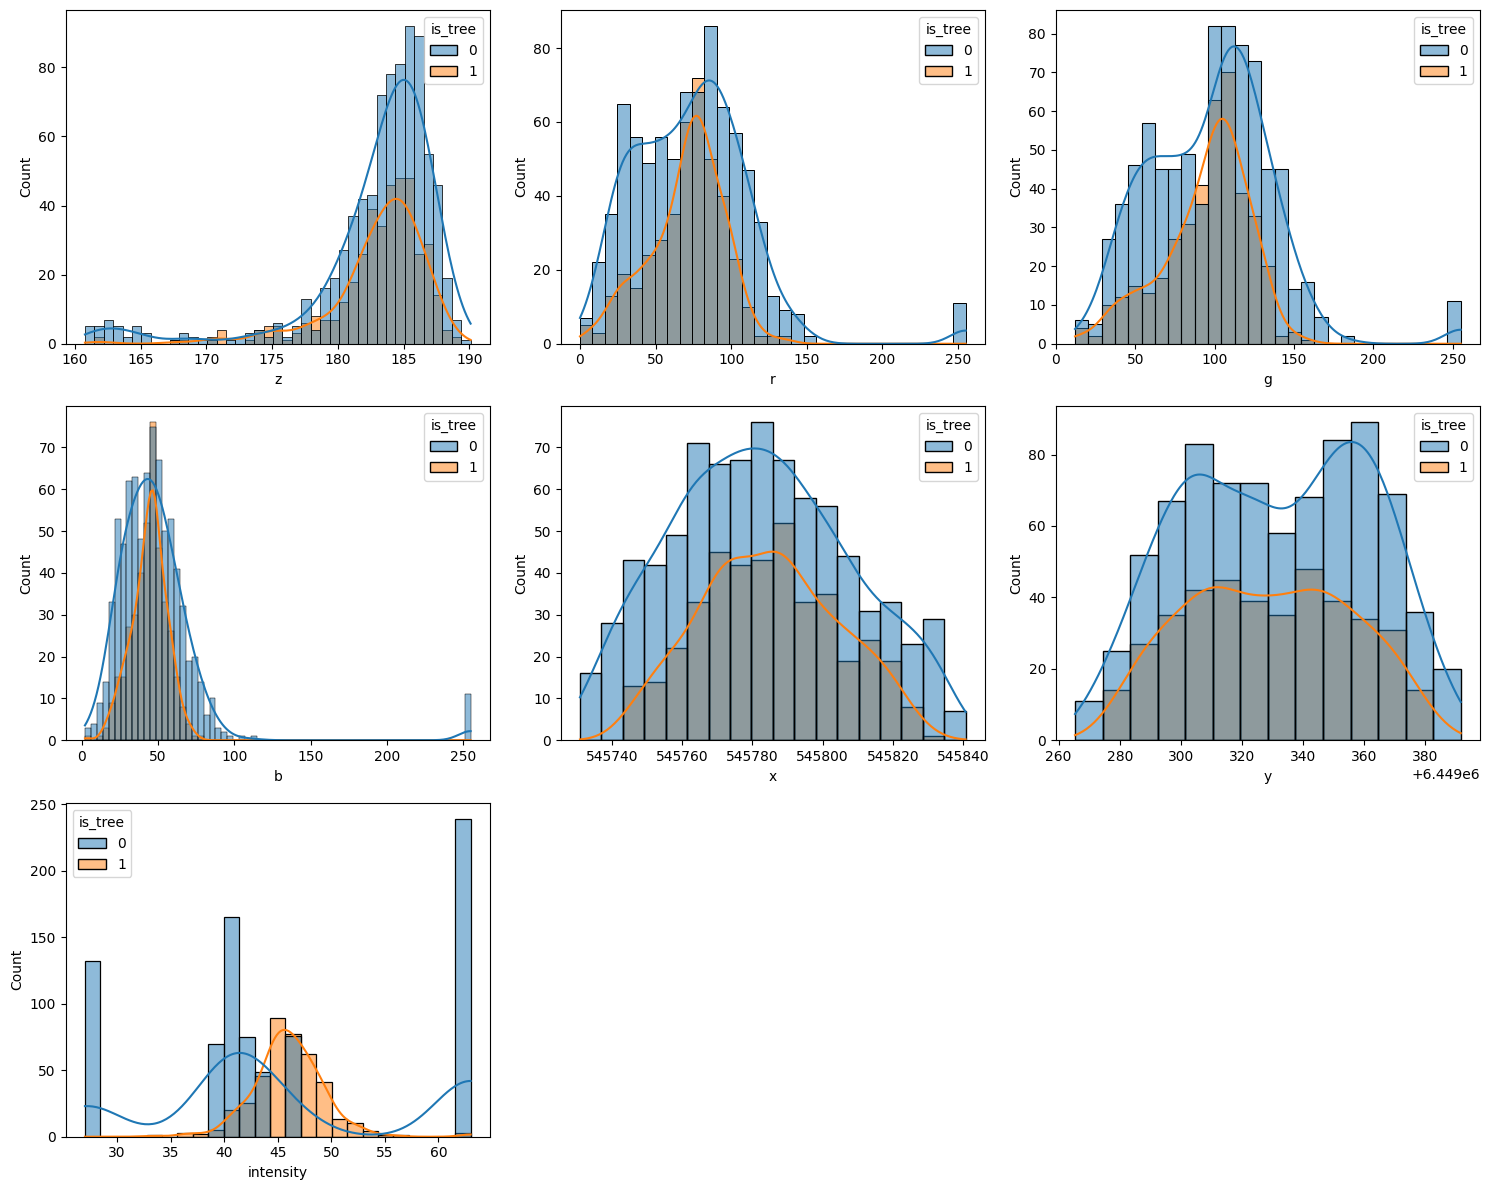

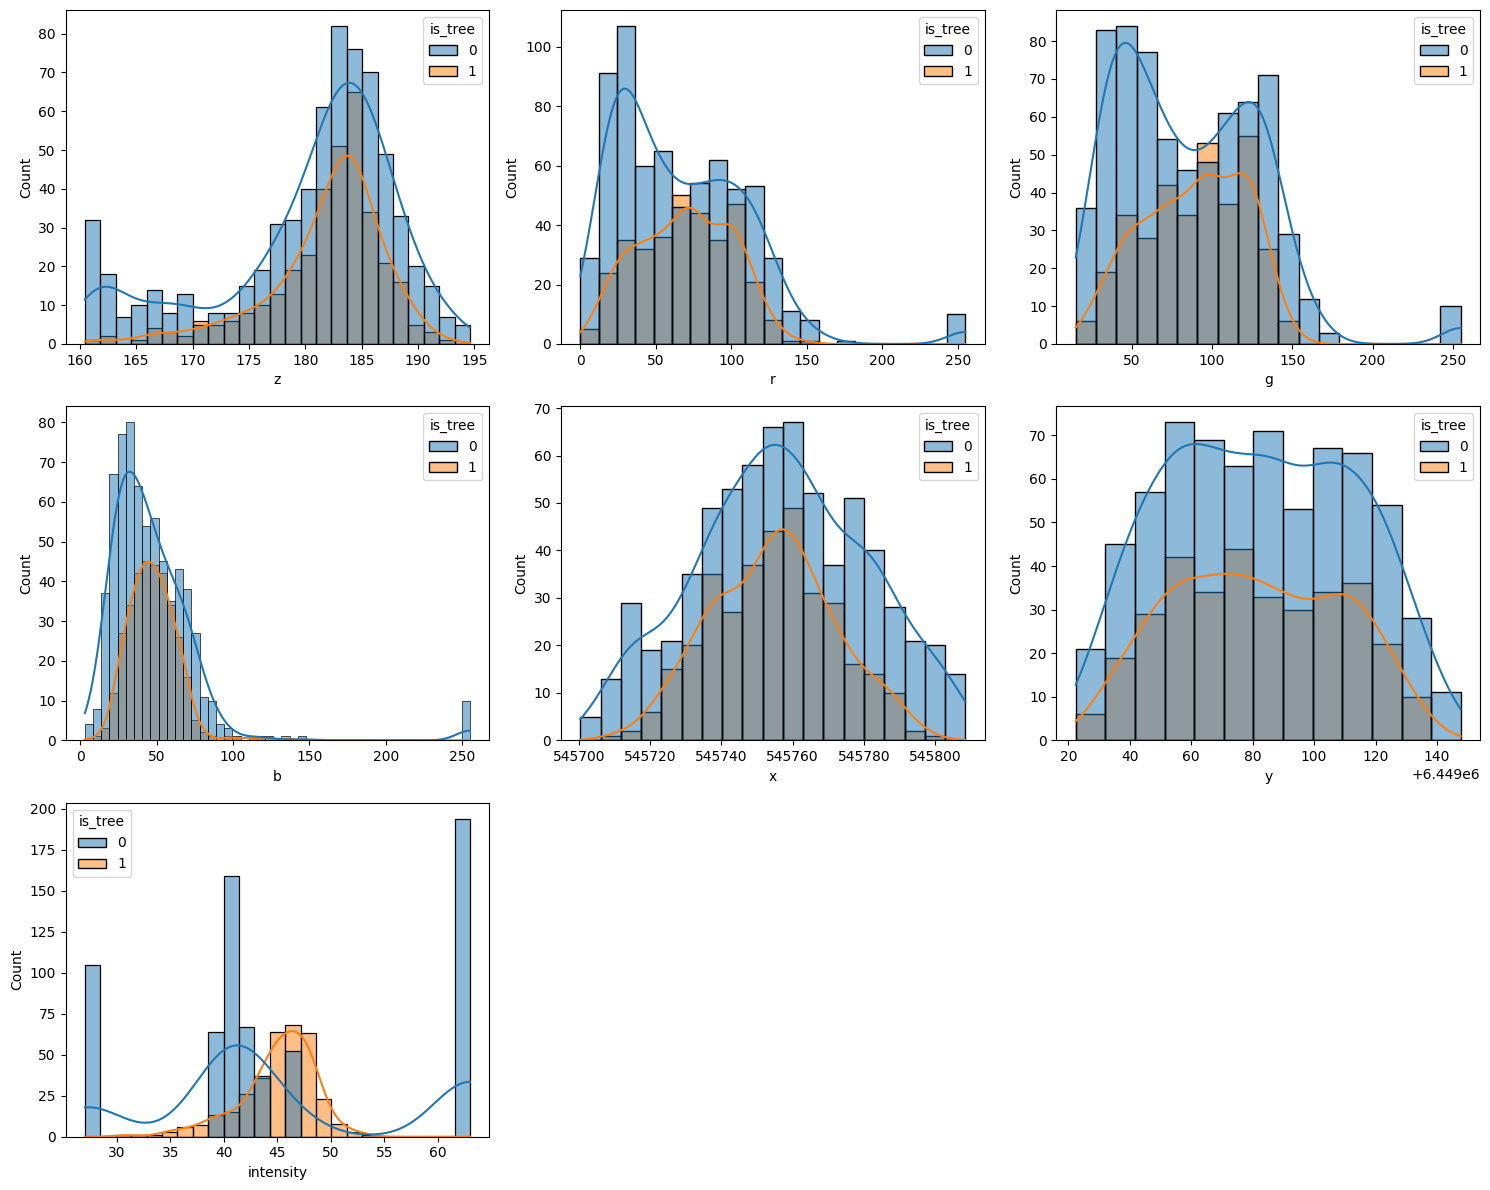

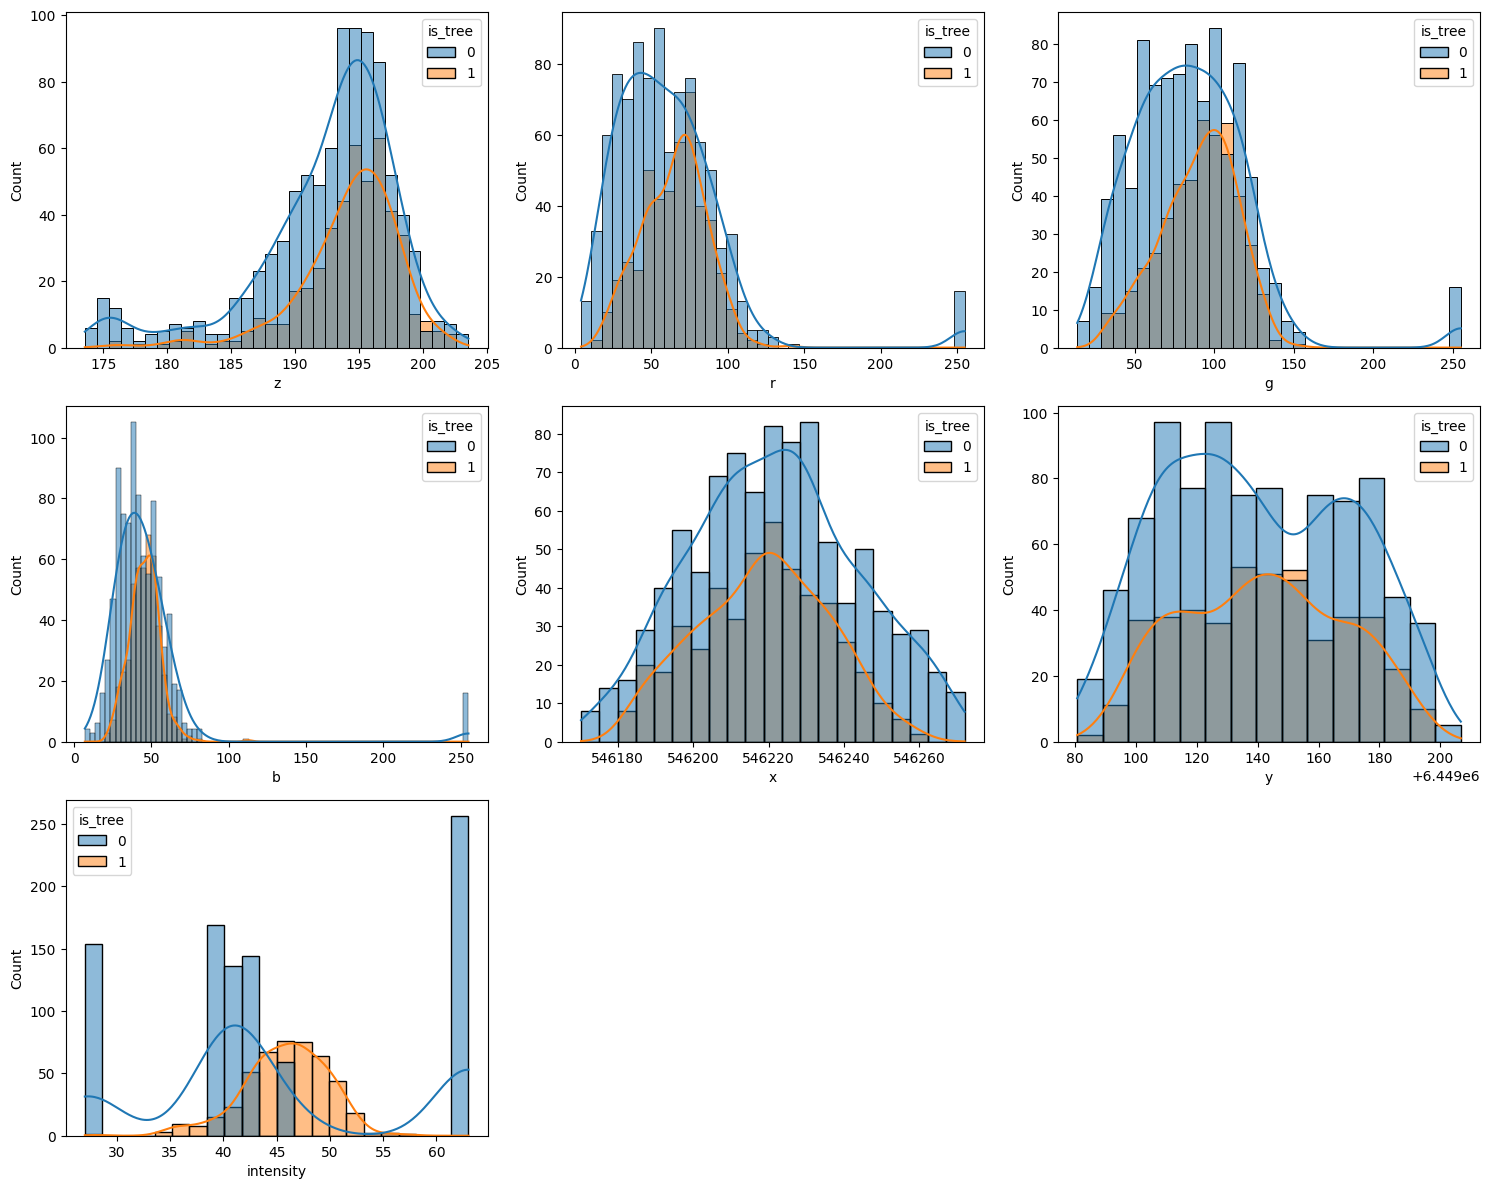

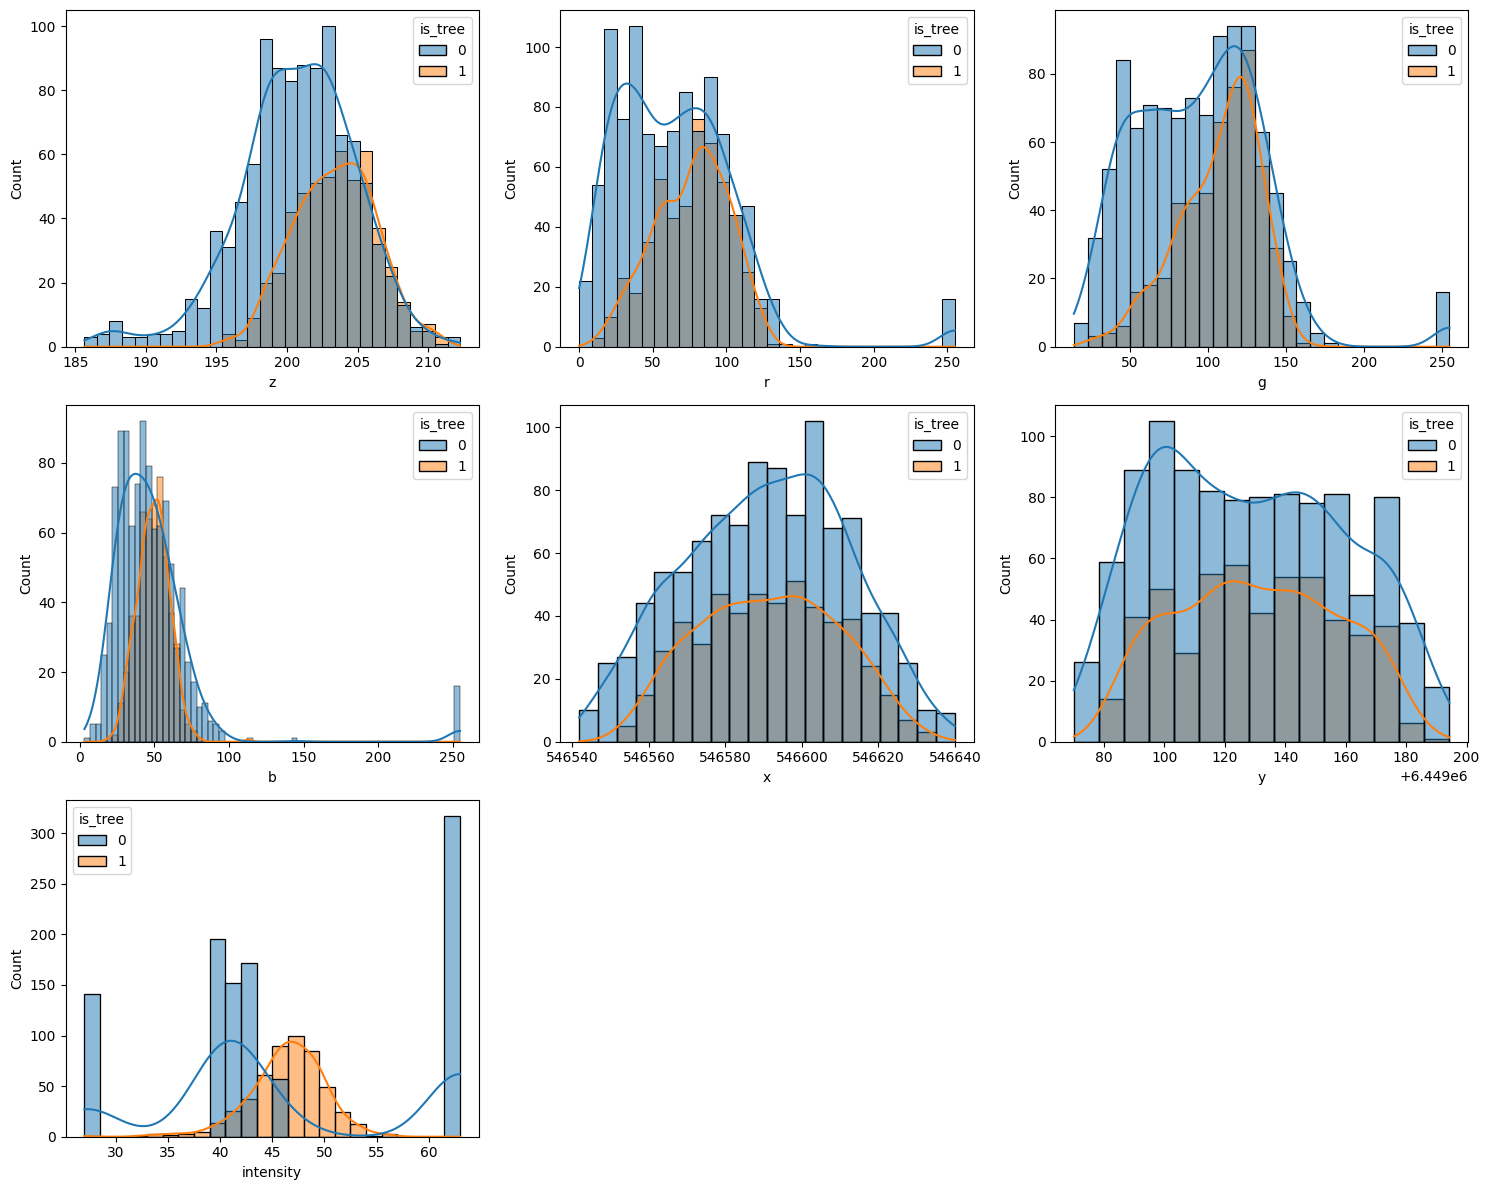

In [36]:
plot_ids = [f"{i:02d}" for i in range(1, 11)]

all_reports = []

for pid in plot_ids:
    try: 
        gdf_las, ground_truth = load_data(pid)
        training_df = match_gt(gdf_las, ground_truth)
        viz(training_df, pid)
        X_train, X_test, y_train, y_test, rfc = model_pipeline(training_df)
        report_df = evaluate(rfc, X_test, y_test)
        report_df["plot_id"] = pid
        all_reports.append(report_df)
    except Exception as e:
        print(f"Error in {pid} - {e}")

if all_reports:
    final_report = pd.concat(all_reports, ignore_index=True)
    final_report.to_csv("rf_report.csv", index=False)
else:
    print("Error in report generation")

In [37]:
rfc.feature_importances_

array([0.05036594, 0.02037066, 0.01948445, 0.02940487, 0.88037408])